# UCI regression 

In [579]:
import jax
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

import datagen
from functools import partial
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gfilter
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"

In [716]:
uci = datagen.UCIDatasets("./data")

dataset_name = "energy"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 50
v_error = 100
for i in range(n_runs):
    data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=0.05, seed=seed_init + i, v_error=v_error)
    X = data["X"]
    y = data["y"]
    ix_clean = ~data["err_where"].astype(bool)
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [717]:
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T

In [718]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Setup

In [767]:
lr = 0.1
Q = 0.0

def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [768]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [769]:
Q = 0.0
observation_covariance = 1.0

In [770]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

## EKF

In [771]:
agent = gfilter.ExtendedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=Q,
    observation_covariance=1.0 * jnp.eye(1),
)

bel_init = agent.init_bel(params_init, cov=lr)

callback = partial(callback_fn, applyfn=agent.vobs_fn)

In [772]:
%%time
callback = partial(callback_fn, applyfn=agent.vobs_fn)
res = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
res = jax.block_until_ready(res)
state_final_collection, yhat_collection_ekf = res
yhat_collection_ekf = yhat_collection_ekf.squeeze()

CPU times: user 3.45 s, sys: 49.2 ms, total: 3.5 s
Wall time: 7.14 s


In [773]:
err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)
summ_collection_ekf = err_collection_ekf.expanding(10).mean()

## WLF-IMQ

### Hparam choice

In [774]:
def filter_imqf(soft_threshold):
    agent = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.link_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(soft_threshold):
    res = -jnp.power(filter_imqf(soft_threshold)[0] - y, 2)[ix_clean].mean()
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [775]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "soft_threshold": (1e-6, 20),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize()

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -0.1344   | 11.77     |
| 3         | -0.1122   | 5.301     |
| 7         | -0.1116   | 4.029     |
CPU times: user 3min, sys: 2min 53s, total: 5min 54s
Wall time: 21.7 s


### Eval

In [776]:
soft_threshold = bo.max["params"]["soft_threshold"]
agent = gbfilter.IMQFilter(
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0,
    soft_threshold=soft_threshold
)

In [777]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.link_fn)
_, yhat_collection_wlf = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_wlf = jax.block_until_ready(yhat_collection_wlf.squeeze())

CPU times: user 3.52 s, sys: 175 ms, total: 3.7 s
Wall time: 7.21 s


In [778]:
err_collection_wlf = pd.DataFrame(np.power(y_collection - yhat_collection_wlf, 2).T)

## IW-based EKF
(Agamenoni 2012)

### Hparam choice

In [779]:
def filter_rkf(noise_scaling):
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=1
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

In [780]:
def opt_step(noise_scaling):
    res = -jnp.power(filter_rkf(noise_scaling)[0] - y, 2)[ix_clean].mean()
    if np.isnan(res):
        res = -1e+6
    
    return res

In [781]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "noise_scaling": (1e-6, 10)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   | noise_... |
-------------------------------------
| 6         | -0.1105   | 8.274     |
| 34        | -0.1105   | 8.034     |
CPU times: user 2min 54s, sys: 3min 2s, total: 5min 57s
Wall time: 14.6 s


### Eval

In [782]:
noise_scaling = bo.max["params"]["noise_scaling"]

agent = rfilter.ExtendedRobustKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    prior_observation_covariance=1.0 * jnp.eye(1),
    n_inner=1,
    noise_scaling=noise_scaling,
)

In [783]:
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.vobs_fn)
_, yhat_collection_ann1 = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ann1 = yhat_collection_ann1.squeeze()

In [784]:
err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)

## Mahalanobis-based EKF
(Ting 2007)

### Hparam section

In [785]:
def filter_mah_ekf(threshold):
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out

In [786]:
%%time
bo = BayesianOptimization(
    lambda threshold: -jnp.power(filter_mah_ekf(threshold)[0] - y, 2)[ix_clean].mean(),
    pbounds={
        "threshold": (1e-6, 20)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   | threshold |
-------------------------------------
| 3         | -0.1097   | 5.301     |
| 31        | -0.1094   | 4.22      |
CPU times: user 3min 5s, sys: 2min 57s, total: 6min 3s
Wall time: 25.2 s


### Eval

In [787]:
threshold = bo.max["params"]["threshold"]
agent = rfilter.ExtendedThresholdedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
    threshold=threshold,
)

In [788]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.vobs_fn)
_, yhat_collection_mekf = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_mekf = jax.block_until_ready(yhat_collection_mekf)
yhat_collection_mekf = yhat_collection_mekf.squeeze()

CPU times: user 3.36 s, sys: 143 ms, total: 3.5 s
Wall time: 7.24 s


In [789]:
err_collection_mekf = pd.DataFrame(np.power(y_collection - yhat_collection_mekf, 2).T)

## Online SGD

In [790]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

In [811]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    optax.adam(0.1),
    buffer_size=1,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=1
)

callback = partial(callback_fn, applyfn=model.apply)

bel_init = agent.init_bel(params_init)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)[ix_clean]
jnp.sqrt(jnp.power(errs, 2).mean())

Array(2.596912, dtype=float32)

In [812]:
%%time
_, yhat_collection_ogd = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ogd = jax.block_until_ready(yhat_collection_ogd)
yhat_collection_ogd = yhat_collection_ogd.squeeze()

CPU times: user 776 ms, sys: 25.5 ms, total: 802 ms
Wall time: 636 ms


In [813]:
err_collection_ogd  = pd.DataFrame(np.power(y_collection - yhat_collection_ogd, 2).T)

# Results

In [814]:
import seaborn as sns

In [815]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.mul(mask_clean).sum(axis=0) / mask_clean.sum(axis=0),
    "EKF": err_collection_ekf.mul(mask_clean).sum(axis=0) / mask_clean.sum(axis=0),
    "OGD": err_collection_ogd.mul(mask_clean).sum(axis=0) / mask_clean.sum(axis=0),
    "M-EKF": err_collection_mekf.mul(mask_clean).sum(axis=0) / mask_clean.sum(axis=0),
    "E-ANN-1": err_collection_ann1.mul(mask_clean).sum(axis=0) / mask_clean.sum(axis=0),
})

df_results.describe()

,WLF-IMQ,EKF,OGD,M-EKF,E-ANN-1
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.118218,18.526534,7.095373,0.114904,0.116232
std,0.009154,10.747904,2.985651,0.008782,0.009117
min,0.100291,2.840201,2.604806,0.100728,0.097658
25%,0.112087,11.737072,4.597081,0.109201,0.109748
50%,0.117724,16.470035,6.631927,0.113724,0.115318
75%,0.123490,23.885724,8.504703,0.119579,0.120566
max,0.145687,51.487933,15.797383,0.144559,0.142091


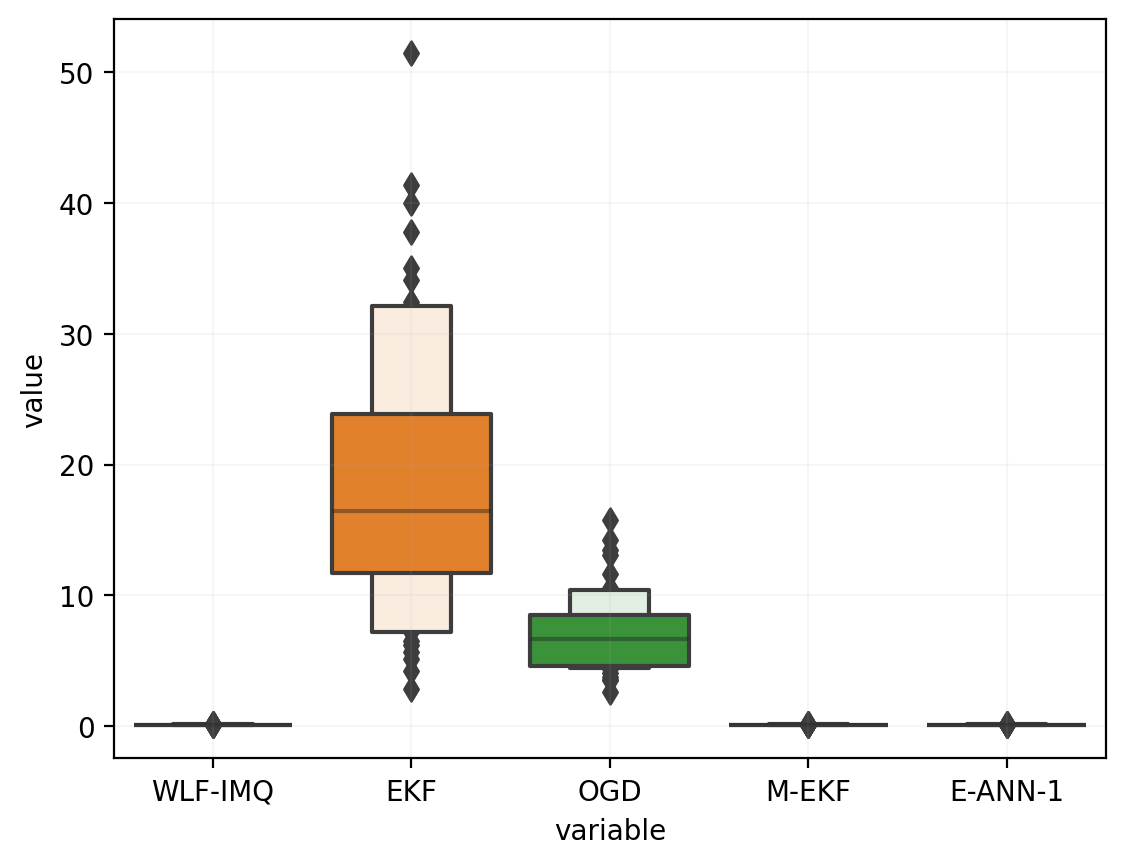

In [816]:
sns.boxenplot(
    x="variable",
    y="value",
    data=df_results.melt(),
)
plt.grid(alpha=0.1)